# 0. Clone Repo & Install Dependencies

In [1]:
import os

if os.path.exists('/content'):
    from google.colab import drive
    drive.mount('/content/drive')

    # Change the current working directory
    os.chdir('/content/drive/MyDrive/git/tensortrade-train')

# Print the current working directory
print("Working directory: {0}".format(os.getcwd()))

Working directory: /home/localadmin/tensortrade-train


## 0.1 Clone/update repo

In [2]:
# if not os.path.isdir(os.getcwd()+'/.git'):
#   !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
# else:  # repo already exists, update it
#   !git pull origin master

## 0.2 Install dependencies
Check GPU availability

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0 or gpu_info.find('not found')>=0)
if gpu_available:
  print('GPU available')
  print(gpu_info)
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def get_gpu_count():
    return len(get_available_gpus())

gpu_count = get_gpu_count()
print(f'GPU count: {gpu_count}')

2021-07-16 11:56:40.728153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-16 11:56:40.728169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


GPU count: 0


2021-07-16 11:56:41.468195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-16 11:56:41.468608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-16 11:56:41.468618: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-16 11:56:41.468629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localadmin-ECA-FX44E4C): /proc/driver/nvidia/version does not exist


Install requirements

In [5]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [6]:
# gpu_available=False
# if gpu_available:
#   print("Installing GPU requirement packages")
#   !pip install -r requirements.ray.txt
# else:
#   print("Installing non-GPU requirement packages")
#   !pip install -r requirements.ray.no-gpu.txt

## Imports

In [7]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default

%matplotlib inline

## Load Instruments

In [8]:
from tensortrade.oms.instruments import Instrument

TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [9]:
training_data_path = 'data/sine-fixed-15m-btc-usdt.csv'
testing_data_path = 'data/sine-fixed-15m-btc-usdt.csv'

In [10]:
# df = pd.read_csv(training_data_path)
# df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# df['date'] = pd.to_datetime(df['date'])
# df.head()

In [11]:
amp = 50
offset = 100

# amp = 50
offset = 30000

x = np.arange(0, 2 * np.pi, 2 * np.pi / 1001)
y = amp * np.sin(3 * x) + offset

df = pd.DataFrame()
df['close'] = y

### Create the dataset features

In [12]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def add_indicators(df, fillna=False):    
    df['close_diff'] = difference(df['close'], inplace=False)
    df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    df['close_mean'] = mean_normalize(df['close'], inplace=False)
    
    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)
    
    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)
    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)
    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)

    df['ema25_50_diff'] = df['ema25']-df['ema50']
    df['ema25_50_diff_norm'] = 1-df['ema50']/df['ema25']
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']
    df['ema10_25_diff_norm'] = 1-df['ema25']/df['ema10']
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [13]:
add_indicators(df, fillna=False)

In [14]:
total_data_steps = len(df)
print(total_data_steps)

952


In [15]:
# import ta
# dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
# dataset.head(3)

### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [16]:
price_history = df[['close']]
display(price_history.head(3))

,close
0,30039.861889
1,30040.423161
2,30040.970099


In [17]:
# price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
# display(price_history.head(3))

In [18]:
# price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']] 
# display(price_history.head(3))

# dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

<AxesSubplot:>

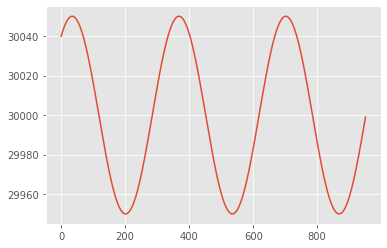

In [19]:
price_history['close'].plot(grid=True)

<AxesSubplot:>

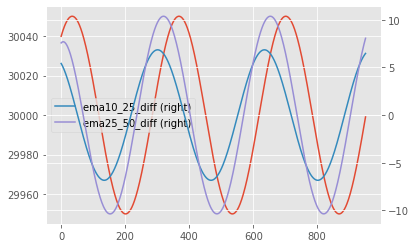

In [20]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [21]:
# !pip install mplfinance

In [22]:
# import mplfinance as mpf
# cd = df.copy()  

# # total data length in dataset
# data_length = len(cd)
# print(f"Total data length: {data_length}")

# Calculate Indicators

In [23]:
# cd.set_index('date', inplace=True)
# cd

# Plot Price History Chart

In [24]:
# #overlays = df[['ema25', 'ema50']]
# apds = [ 
#          #mpf.make_addplot(overlays, width=0.5), 
#          mpf.make_addplot(cd['emaNormDiff'], panel=2, width=0.5, ylabel='EMA\nNormalized\nDiff'),
#          mpf.make_addplot(cd['macd_diff'], panel=3, width=0.5, ylabel='MACD Diff'),
#        ]
# mpf.plot(cd, type='candle', 
#          style='charles', volume=True,
#          title='BTC/USD Full Data (%d steps)\n%s -> %s' % (data_length, cd.index[0], cd.index[data_length-1]), 
#          addplot=apds, figscale=1.2)

In [25]:
import matplotlib.pyplot as plt

def show_chart(df, columns1, columns2, columns3, title):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[1], grid=True)
    df[columns3].plot(ax=axs[2], grid=True)

In [26]:
columns1 = ['close']
columns2 = ['ema10_25_diff', 'ema25_50_diff']
columns3 = ['close_diff', 'trend_ema10_25', 'trend_ema25_50', 'macd_diff']

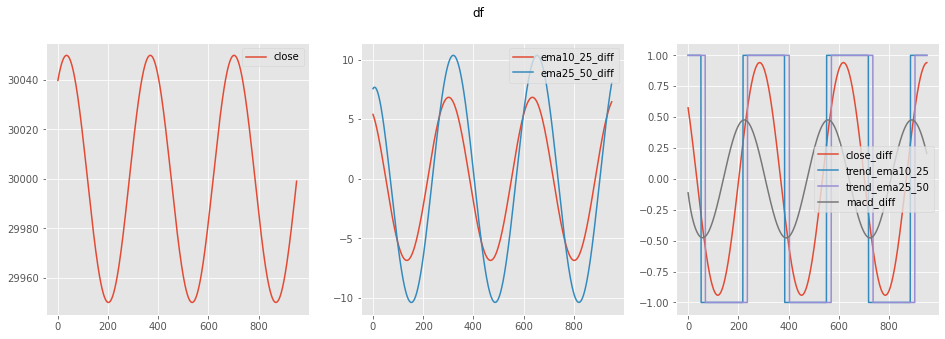

In [27]:
show_chart(df, columns1, columns2, columns3, 'df')

### Create Streams

In [28]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [29]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [30]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [31]:
feed = DataFeed([
    Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC"),
    #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
    Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
    #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
    Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

    #Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
    #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

    #Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
    Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

    #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
])

In [32]:
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [33]:
feed.next()

{'USD-TTC': 30039.861888678857,
 'price_log_diff': 0,
 'close_diff': 0.575406514963106,
 'trend_ema25_50': 1}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [34]:
# from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

# chart_renderer = PlotlyTradingChart(
#     display=True,  # show the chart on screen (default)
#     height=800,  # affects both displayed and saved file height. None for 100% height.
#     save_format="html",  # save the chart to an HTML file
#     auto_open_html=True,  # open the saved HTML chart in a new browser tab
# )

# file_logger = FileLogger(
#     filename="example.log",  # omit or None for automatic file name
#     path="training_logs"  # create a new directory if doesn't exist, None for no directory
# )

### Create Exchange & Portfolio

In [35]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    close
)

initial_capital = 1000

cash = Wallet(bitfinex, initial_capital * USD)
asset = Wallet(bitfinex, 0 * TTC)

portfolio = Portfolio(USD, [
    cash,
    asset
])

### Reward & Action Scheme

In [36]:
# reward_scheme="risk-adjusted"
# action_scheme="managed-risk"

reward_scheme = default.rewards.PBR(price=close)
action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

### Renderer Feed

In [37]:
# renderer_feed = DataFeed([
#     Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
# )

In [38]:
renderer_feed = DataFeed([
    Stream.source(price_history['close'].tolist(), dtype="float").rename("price"),
    Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
])

In [39]:
# renderer_feed = DataFeed([
#     Stream.source(y, dtype="float").rename("price"),
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [40]:
# renderer_feed = DataFeed([
#     price,
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [41]:
# renderer_feed = DataFeed([
#     close
# ])

### Setup Environment

In [42]:
# from PositionChangeChart import PositionChangeChart

# def create_env(config):
#     env = default.create(
#         feed=feed,
#         portfolio=portfolio,
#         action_scheme=action_scheme,
#         reward_scheme=reward_scheme,
#         renderer_feed=renderer_feed,
#         renderer=PositionChangeChart(),
#         window_size=config["window_size"],
#         max_allowed_loss=0.6
#     )
#     return env

In [43]:
from PositionChangeChart import PositionChangeChart
  
def get_price_series():
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 1000
    return y

def get_exchange(stream):
    return Exchange("bitfinex", service=execute_order)(
        stream
    )

def get_cash_asset(exchange):
    return [
        Wallet(exchange, 1000 * USD), 
        Wallet(exchange, 0 * TTC)
    ]

In [44]:
def create_env(config):  
#     close = get_price_series()
    df = config['df']
    
    p = Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC")
  
    bitfinex = get_exchange(p)
#     bitfinex = Exchange("bitfinex", service=execute_order)(p)
    
    [cash, asset] = get_cash_asset(bitfinex)

    portfolio = Portfolio(USD, [cash, asset])
    
    reward_scheme = default.rewards.PBR(price=p)
    action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'].tolist(), dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])
    
#     feed = DataFeed([
#         p,
#         p.rolling(window=10).mean().rename("fast"),
#         p.rolling(window=50).mean().rename("medium"),
#         p.rolling(window=100).mean().rename("slow"),
#         p.log().diff().fillna(0).rename("lr")
#     ])
    
    feed = DataFeed([
        #p,
        #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
        #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
        #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
        Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

        #Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
        #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

        Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
        #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

        #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

## Setup and Train Agent

In [47]:
import os
import ray
from ray import tune
from ray.tune.registry import register_env

register_env("TradingEnv", create_env)

analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)


2021-07-16 11:56:42,837	INFO resource_spec.py:223 -- Starting Ray with 6.74 GiB memory available for workers and up to 3.39 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-07-16 11:56:43,341	INFO services.py:1191 -- View the Ray dashboard at localhost:8267


Trial name,status,loc
PPO_TradingEnv_d625d_00000,RUNNING,


(pid=21034) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=21034) Instructions for updating:
(pid=21034) non-resource variables are not supported in the long term
(pid=21034) 2021-07-16 11:56:46,638	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=21034) 2021-07-16 11:56:46,639	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f31af6ff880>: Box(-inf, inf, (25, 2), float32) -> (25, 2)
(pid=21034) 2021-07-16 11:56:46,644	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f31af6ff0a0>}
(pid=21034) 2021-07-16 11:56:46,644	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.prepro

(pid=21038) 2021-07-16 11:56:49,919	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=21038) 2021-07-16 11:56:49,920	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f103adcc8e0>: Box(-inf, inf, (25, 2), float32) -> (25, 2)
(pid=21038) 2021-07-16 11:56:49,928	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=21038) 2021-07-16 11:56:49,929	DEBUG rollout_worker.py:538 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7f103ad7e6a0> (<TradingEnv instance>), policies {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f103ad7e6d0>}
(pid=21038) /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to t

(pid=21047) 2021-07-16 11:56:50,712	INFO sample_batch_builder.py:202 -- Trajectory fragment after postprocess_trajectory():
(pid=21047) 
(pid=21047) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-0.014, max=0.012, mean=-0.0),
(pid=21047)                         'action_logp': np.ndarray((200,), dtype=float32, min=-0.701, max=-0.685, mean=-0.693),
(pid=21047)                         'action_prob': np.ndarray((200,), dtype=float32, min=0.496, max=0.504, mean=0.5),
(pid=21047)                         'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.465),
(pid=21047)                         'advantages': np.ndarray((200,), dtype=float32, min=-2.329, max=2.662, mean=-0.333),
(pid=21047)                         'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=21047)                         'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=21047)                         'eps_id':

(pid=21034) 2021-07-16 11:56:52,091	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.6068569737853426, 'policy_loss': -0.026543603222252743, 'vf_loss': 1.280300169280081, 'vf_explained_var': -0.27262497, 'kl': 0.0008660618782001125, 'entropy': 0.6922712488607927, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:52,278	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.5132038855191433, 'policy_loss': -0.04701371725197091, 'vf_loss': 1.1331717390002627, 'vf_explained_var': -0.13390483, 'kl': 0.00268162601754408, 'entropy': 0.6904596198688854, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:52,458	DEBUG sgd.py:120 -- 3 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.45415622447476245, 'policy_loss': -0.07117710691509825, 'vf_loss': 1.0619501634077593, 'vf_explained_var': -0.06306782, 'kl': 0.006142479847326424, 'entropy': 0.6870238293300975, 'e

(pid=21034) 2021-07-16 11:56:56,259	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.3193395733833313, 'policy_loss': -0.18572976620811404, 'vf_loss': 0.9990752140680949, 'vf_explained_var': -0.0017201792, 'kl': 0.05946867596922499, 'entropy': 0.6362002762881193, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:56,412	DEBUG sgd.py:120 -- 26 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.3177371273438136, 'policy_loss': -0.1874501019942038, 'vf_loss': 0.9992563020099293, 'vf_explained_var': -0.0014141257, 'kl': 0.05959905683994293, 'entropy': 0.6360730655265577, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:56,572	DEBUG sgd.py:120 -- 27 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.3175960575992411, 'policy_loss': -0.18735373099193428, 'vf_loss': 0.9988158363284487, 'vf_explained_var': -0.0009668867, 'kl': 0.059516206948143066, 'entropy': 0.636136820822051

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-56-56
  done: false
  episode_len_mean: 588.3333333333334
  episode_reward_max: -2.7349737785225443
  episode_reward_mean: -10.418797723144962
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 3
  episodes_total: 3
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.6366743716326627
        entropy_coeff: 0.01
        kl: 0.058896892788735306
        policy_loss: -0.18821148495330955
        total_loss: 0.31684848711346136
        vf_explained_var: -0.0013237090315669775
        vf_loss: 0.9992946729515538
    num_steps_sampled: 4200
    num_steps_trained: 4200
  iterations_since_restore: 1
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 5

(pid=21034) 2021-07-16 11:56:56,886	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.31684848711346136, 'policy_loss': -0.18821148495330955, 'vf_loss': 0.9992946729515538, 'vf_explained_var': -0.001323709, 'kl': 0.058896892788735306, 'entropy': 0.6366743716326627, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:56,908	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=4210, mean_mean=-0.6509717523611203, mean_std=3.746864283430924), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,1,10.1355,4200,-10.4188


(pid=21034) 2021-07-16 11:56:58,382	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.4475069885904139, 'policy_loss': -0.04128544272459818, 'vf_loss': 0.9887756018927603, 'vf_explained_var': -0.00078543206, 'kl': 0.002011583909506348, 'entropy': 0.6198837179126162, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:58,536	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.35519561577926984, 'policy_loss': -0.13566749226866345, 'vf_loss': 0.9827776876362887, 'vf_explained_var': -0.0005351305, 'kl': 0.017151948375006516, 'entropy': 0.5671328035267916, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:56:58,692	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.3216180182767637, 'policy_loss': -0.17108606885779987, 'vf_loss': 0.9774592518806458, 'vf_explained_var': 0.00037035617, 

(pid=21034) 2021-07-16 11:57:02,153	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.24286694892428137, 'policy_loss': -0.25567009751543857, 'vf_loss': 0.9308979186144742, 'vf_explained_var': 0.002328504, 'kl': 0.12427158924666318, 'entropy': 0.41933893796169397, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:02,308	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.24218538922793936, 'policy_loss': -0.25614016886913415, 'vf_loss': 0.9301644744295062, 'vf_explained_var': 0.0024450675, 'kl': 0.12477256854375203, 'entropy': 0.4188450656153939, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:02,463	DEBUG sgd.py:120 -- 26 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.24077227960030237, 'policy_loss': -0.25690865561817633, 'vf_loss': 0.928649618770137, 'vf_explained_var': 0.0027187124, 'k

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-02
  done: false
  episode_len_mean: 613.0
  episode_reward_max: 53.20401956274509
  episode_reward_mean: 10.138647250092617
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 4
  episodes_total: 7
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.00068
        entropy: 0.4196918353889928
        entropy_coeff: 0.01
        kl: 0.12418119202960622
        policy_loss: -0.25782107471516635
        total_loss: 0.23847941376946188
        vf_explained_var: 0.0021332339383661747
        vf_loss: 0.9264861020174894
    num_steps_sampled: 8400
    num_steps_trained: 8400
  iterations_since_restore: 2
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 32

(pid=21034) 2021-07-16 11:57:02,786	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.240138999779116, 'policy_loss': -0.2566304030743512, 'vf_loss': 0.9272779984907671, 'vf_explained_var': 0.0027904385, 'kl': 0.12441138290997708, 'entropy': 0.4193005209619349, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:02,945	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.00068, 'total_loss': 0.23847941376946188, 'policy_loss': -0.25782107471516635, 'vf_loss': 0.9264861020174894, 'vf_explained_var': 0.002133234, 'kl': 0.12418119202960622, 'entropy': 0.4196918353889928, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:02,954	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=8414, mean_mean=-0.5934199802906779, mean_std=3.782200421240243), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,2,16.1572,8400,10.1386


(pid=21034) 2021-07-16 11:57:04,380	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.35382174136060657, 'policy_loss': -0.033340705135329204, 'vf_loss': 0.7807232249866832, 'vf_explained_var': 0.011514037, 'kl': 0.001476193891571269, 'entropy': 0.3863455806717728, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:04,535	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.2945512334505717, 'policy_loss': -0.08892563789744269, 'vf_loss': 0.7656203959927415, 'vf_explained_var': -0.0047900495, 'kl': 0.00890685674367529, 'entropy': 0.3341400207895221, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:04,691	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.27674031257629395, 'policy_loss': -0.10205670773531451, 'vf_loss': 0.7531632690

(pid=21034) 2021-07-16 11:57:07,973	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.191675440803396, 'policy_loss': -0.12863968041810123, 'vf_loss': 0.6152756123831777, 'vf_explained_var': 0.019798137, 'kl': 0.034175091620647545, 'entropy': 0.2701478148951675, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:08,130	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.19023700871250845, 'policy_loss': -0.1280961059824084, 'vf_loss': 0.6113860083348823, 'vf_explained_var': 0.025469799, 'kl': 0.034100718796253204, 'entropy': 0.27052110749663727, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:08,286	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.18840257970221114, 'policy_loss': -0.12786448481633808, 'vf_loss': 0.6073207186

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-08
  done: false
  episode_len_mean: 685.4285714285714
  episode_reward_max: 250.7762279144954
  episode_reward_mean: 106.10732290436447
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 14
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 0.00026000000000000003
        entropy: 0.2705937551729607
        entropy_coeff: 0.01
        kl: 0.033956373844182854
        policy_loss: -0.12845836105671796
        total_loss: 0.18065580006011508
        vf_explained_var: 0.03034730814397335
        vf_loss: 0.593079455874183
    num_steps_sampled: 12600
    num_steps_trained: 12600
  iterations_since_restore: 3
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  pe

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,3,22.0993,12600,106.107


(pid=21034) 2021-07-16 11:57:08,912	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00026000000000000003, 'total_loss': 0.18065580006011508, 'policy_loss': -0.12845836105671796, 'vf_loss': 0.593079455874183, 'vf_explained_var': 0.030347308, 'kl': 0.033956373844182854, 'entropy': 0.2705937551729607, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:08,921	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=12621, mean_mean=-0.22417800320235048, mean_std=3.8438644171247467), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:57:10,273	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.740000000000001e-05, 'total_loss': 0.22407498030048428, 'policy_loss': -0.02356880722623883, 'vf_loss': 0.49955896175268927, 'vf_explained_var': -0.027818963, 'kl': 0.0007176769704497748, 'entropy': 0.2620127155925288, 'entropy_coeff': 0.01}
(pid=21034) 2

(pid=21034) 2021-07-16 11:57:13,577	DEBUG sgd.py:120 -- 21 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.740000000000001e-05, 'total_loss': 0.11336429157491887, 'policy_loss': -0.08330839660696009, 'vf_loss': 0.37892363559116016, 'vf_explained_var': 0.0076336046, 'kl': 0.013512290760197422, 'entropy': 0.19099229258118253, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:13,731	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.740000000000001e-05, 'total_loss': 0.1116181423210285, 'policy_loss': -0.08370147414053931, 'vf_loss': 0.37621659446846356, 'vf_explained_var': 0.009782145, 'kl': 0.013512266912695133, 'entropy': 0.19094604795629327, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:13,888	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.740000000000001e-05, 'total_loss': 0.10987165547681577, 'policy_loss': -0.08426318074943441, 'vf_loss': 0.3738664352532589, 'vf_explained_var': 0.008249648

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-14
  done: false
  episode_len_mean: 755.3157894736842
  episode_reward_max: 467.9610322809094
  episode_reward_mean: 197.6584299714362
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 5
  episodes_total: 19
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.740000000000001e-05
        entropy: 0.19240760983842792
        entropy_coeff: 0.01
        kl: 0.01324876719577746
        policy_loss: -0.08441823664488214
        total_loss: 0.10489366051148284
        vf_explained_var: 0.013068103231489658
        vf_loss: 0.36458611127102014
    num_steps_sampled: 16800
    num_steps_trained: 16800
  iterations_since_restore: 4
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_u

(pid=21034) 2021-07-16 11:57:14,840	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.740000000000001e-05, 'total_loss': 0.10489366051148284, 'policy_loss': -0.08441823664488214, 'vf_loss': 0.36458611127102014, 'vf_explained_var': 0.013068103, 'kl': 0.01324876719577746, 'entropy': 0.19240760983842792, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:14,848	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=16826, mean_mean=-0.28364632579309584, mean_std=3.8333248727620775), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,4,28,16800,197.658


(pid=21034) 2021-07-16 11:57:16,165	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.11891870578807412, 'policy_loss': -0.014127886035677158, 'vf_loss': 0.26923289082267066, 'vf_explained_var': 0.01642709, 'kl': 0.0003352418823506282, 'entropy': 0.17961429420745734, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:16,321	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.08964956721121614, 'policy_loss': -0.04338879375295206, 'vf_loss': 0.2659259555917798, 'vf_explained_var': 0.020827329, 'kl': 0.00239875406083284, 'entropy': 0.1543779495087537, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:16,495	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.08254631162818635, 'policy_loss': -0.05013374148896246, 'vf_loss': 0.2630219739494902, 'vf_explained_var': 0.018350951, 'kl': 0.0038822347608705363, 'entropy': 0.

(pid=21034) 2021-07-16 11:57:20,031	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.06284486100908411, 'policy_loss': -0.06371083669364452, 'vf_loss': 0.24272289149688953, 'vf_explained_var': 0.029630918, 'kl': 0.009512860440846645, 'entropy': 0.12269278164162781, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:20,189	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.06349753311863451, 'policy_loss': -0.06337057903521892, 'vf_loss': 0.24331139660242831, 'vf_explained_var': 0.028370822, 'kl': 0.009538758546113968, 'entropy': 0.12262437876426813, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:20,353	DEBUG sgd.py:120 -- 26 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.06274759289667461, 'policy_loss': -0.06376771801010225, 'vf_loss': 0.24264461976109128, 'vf_explained_var': 0.028778343, 'kl': 0.009512783451513811, 'entropy

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-20
  done: false
  episode_len_mean: 773.952380952381
  episode_reward_max: 467.9610322809094
  episode_reward_mean: 222.66718063844712
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 2
  episodes_total: 21
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.32e-05
        entropy: 0.12279713469924348
        entropy_coeff: 0.01
        kl: 0.009467696855691347
        policy_loss: -0.06406827874933228
        total_loss: 0.062398099594495514
        vf_explained_var: 0.029496077448129654
        vf_loss: 0.2426073138009418
    num_steps_sampled: 21000
    num_steps_trained: 21000
  iterations_since_restore: 5
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent:

(pid=21034) 2021-07-16 11:57:20,667	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.061906706344223385, 'policy_loss': -0.06434995472205407, 'vf_loss': 0.24220346862619574, 'vf_explained_var': 0.028375756, 'kl': 0.009459601912760374, 'entropy': 0.12303064131375516, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:20,833	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.32e-05, 'total_loss': 0.062398099594495514, 'policy_loss': -0.06406827874933228, 'vf_loss': 0.2426073138009418, 'vf_explained_var': 0.029496077, 'kl': 0.009467696855691347, 'entropy': 0.12279713469924348, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,5,33.9686,21000,222.667


(pid=21034) 2021-07-16 11:57:20,841	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=21028, mean_mean=-0.24708256527330572, mean_std=3.8538105688079947), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:57:22,160	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.07226993465288119, 'policy_loss': -0.009093214701296705, 'vf_loss': 0.1648861181103822, 'vf_explained_var': 0.01800599, 'kl': 0.00016399651137856029, 'entropy': 0.11906074529344385, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:22,314	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.05243835852227428, 'policy_loss': -0.029514137655496597, 'vf_loss': 0.1645076640627601, 'vf_explained_var': 0.017238226, 'kl': 0.001111746188888157, 'entropy': 0.10517639937725934, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:

(pid=21034) 2021-07-16 11:57:25,644	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.037114829643431935, 'policy_loss': -0.04584684347112974, 'vf_loss': 0.1590757000852715, 'vf_explained_var': 0.021417942, 'kl': 0.0062513497065414085, 'entropy': 0.07958364847934607, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:25,798	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.036415681722715046, 'policy_loss': -0.046464262163322986, 'vf_loss': 0.15875328388629537, 'vf_explained_var': 0.032001052, 'kl': 0.006363663003977501, 'entropy': 0.07921737229282205, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:25,958	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.03699660233475945, 'policy_loss': -0.045981624417684296, 'vf_loss': 0.15886566426717874, 'vf_explained_var': 0.0284

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-26
  done: false
  episode_len_mean: 818.2142857142857
  episode_reward_max: 534.5826416023701
  episode_reward_mean: 298.8675499311482
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 28
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 8.900000000000001e-05
        entropy: 0.07830610543941006
        entropy_coeff: 0.01
        kl: 0.0066926636253342485
        policy_loss: -0.047048058389036945
        total_loss: 0.036031144699364
        vf_explained_var: 0.030753569677472115
        vf_loss: 0.15868943478121902
    num_steps_sampled: 25200
    num_steps_trained: 25200
  iterations_since_restore: 6
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_

(pid=21034) 2021-07-16 11:57:26,629	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.03503642821063598, 'policy_loss': -0.047599782800358356, 'vf_loss': 0.1578218054139253, 'vf_explained_var': 0.032296468, 'kl': 0.006678243012477954, 'entropy': 0.07825044068423184, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:26,782	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.900000000000001e-05, 'total_loss': 0.036031144699364, 'policy_loss': -0.047048058389036945, 'vf_loss': 0.15868943478121902, 'vf_explained_var': 0.03075357, 'kl': 0.0066926636253342485, 'entropy': 0.07830610543941006, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:26,791	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=25235, mean_mean=-0.303870967342848, mean_std=3.839891815616617), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,6,39.8907,25200,298.868


(pid=21034) 2021-07-16 11:57:28,061	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.04636720565119476, 'policy_loss': -0.004436637020923875, 'vf_loss': 0.10292799567634409, 'vf_explained_var': 0.018193008, 'kl': 5.6756071794117346e-05, 'entropy': 0.06984645873308182, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:28,214	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.032944140024483204, 'policy_loss': -0.017623000411373196, 'vf_loss': 0.10187736469687837, 'vf_explained_var': -0.016216742, 'kl': 0.0003804828125849423, 'entropy': 0.06283635431618402, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:28,375	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.027329435628471954, 'policy_loss': -0.02334219335832379, 'vf_loss': 0.10145026930805409, 'vf_explained_var': 0.02502755, 'kl': 0.0007934919258607833, 'en

(pid=21034) 2021-07-16 11:57:31,793	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.017161511957193867, 'policy_loss': -0.035210707196683594, 'vf_loss': 0.10014967878603122, 'vf_explained_var': -0.0063348757, 'kl': 0.004055627685209567, 'entropy': 0.04401685009625825, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:31,946	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.01695750837186069, 'policy_loss': -0.03542413765733892, 'vf_loss': 0.10007373881385181, 'vf_explained_var': 0.009497623, 'kl': 0.004121986556459557, 'entropy': 0.043756595558740875, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:32,103	DEBUG sgd.py:120 -- 26 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.01861925366701502, 'policy_loss': -0.03420799019548929, 'vf_loss': 0.10088261352343993, 'vf_explained_var': 0.0296477, 'kl': 0.004183453042060137, 'entr

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-32
  done: false
  episode_len_mean: 831.0645161290323
  episode_reward_max: 553.079364528101
  episode_reward_mean: 323.1330839349767
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 3
  episodes_total: 31
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 8.48e-05
        entropy: 0.043063451620665466
        entropy_coeff: 0.01
        kl: 0.0043965226011068535
        policy_loss: -0.036188232373784886
        total_loss: 0.01637920607445818
        vf_explained_var: -0.00583766819909215
        vf_loss: 0.1000608370046724
    num_steps_sampled: 29400
    num_steps_trained: 29400
  iterations_since_restore: 7
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent

(pid=21034) 2021-07-16 11:57:32,428	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.01774888231673024, 'policy_loss': -0.03514067958475965, 'vf_loss': 0.10078511023047296, 'vf_explained_var': -0.0012883563, 'kl': 0.004339802361121683, 'entropy': 0.04323568387013493, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:32,581	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.48e-05, 'total_loss': 0.01637920607445818, 'policy_loss': -0.036188232373784886, 'vf_loss': 0.1000608370046724, 'vf_explained_var': -0.005837668, 'kl': 0.0043965226011068535, 'entropy': 0.043063451620665466, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:32,589	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=29438, mean_mean=-0.28857160496726547, mean_std=3.849581136245981), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,7,45.6591,29400,323.133


(pid=21034) 2021-07-16 11:57:33,839	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.02673643720195149, 'policy_loss': -0.003168933195852195, 'vf_loss': 0.060634594170771765, 'vf_explained_var': -0.1479423, 'kl': 2.920458746974946e-05, 'entropy': 0.042178334442503525, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:33,993	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.02215518057346344, 'policy_loss': -0.00835590199990706, 'vf_loss': 0.06164605646027309, 'vf_explained_var': -0.10112195, 'kl': 0.0002690224826051924, 'entropy': 0.04027428991641059, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:34,151	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.016964176302832184, 'policy_loss': -0.013176926609241602, 'vf_loss': 0.06066940801048821, 'vf_explained_var': -0.1

(pid=21034) 2021-07-16 11:57:37,307	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.0081440509212288, 'policy_loss': -0.022101737107291367, 'vf_loss': 0.05996226595545357, 'vf_explained_var': -0.014618384, 'kl': 0.001676877486082076, 'entropy': 0.030129110525277527, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:37,460	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.00886147627324769, 'policy_loss': -0.021591574884951115, 'vf_loss': 0.06030765473560402, 'vf_explained_var': -0.121910006, 'kl': 0.0017777772260491145, 'entropy': 0.03007754183967005, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:37,619	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.008992854251780293, 'policy_loss': -0.021555457377072536, 'vf_loss': 0.06044950361617587, 'vf_explained_var': 

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-38
  done: false
  episode_len_mean: 844.7714285714286
  episode_reward_max: 553.079364528101
  episode_reward_mean: 348.5982706030448
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 4
  episodes_total: 35
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.060000000000001e-05
        entropy: 0.029034188045471004
        entropy_coeff: 0.01
        kl: 0.0020566789228751354
        policy_loss: -0.023051525466144085
        total_loss: 0.007293811406601559
        vf_explained_var: -0.155987948179245
        vf_loss: 0.05988310228073687
    num_steps_sampled: 33600
    num_steps_trained: 33600
  iterations_since_restore: 8
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cp

(pid=21034) 2021-07-16 11:57:38,410	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.060000000000001e-05, 'total_loss': 0.007293811406601559, 'policy_loss': -0.023051525466144085, 'vf_loss': 0.05988310228073687, 'vf_explained_var': -0.15598795, 'kl': 0.0020566789228751354, 'entropy': 0.029034188045471004, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,8,51.4685,33600,348.598


(pid=21034) 2021-07-16 11:57:38,424	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=33642, mean_mean=-0.3130954618409067, mean_std=3.844843251419002), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:57:39,678	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.028291930811423244, 'policy_loss': -0.0007153338555133704, 'vf_loss': 0.05864668231824356, 'vf_explained_var': -0.11901273, 'kl': 2.8075890212738003e-05, 'entropy': 0.032081120647490025, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:39,835	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.02360568115149032, 'policy_loss': -0.005216174871858322, 'vf_loss': 0.058242958702259894, 'vf_explained_var': -0.2105845, 'kl': 5.267915190470927e-05, 'entropy': 0.030851879495788704, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:39,994	DEBUG 

(pid=21034) 2021-07-16 11:57:43,204	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.008828579391719717, 'policy_loss': -0.0200900219267968, 'vf_loss': 0.05790223226402745, 'vf_explained_var': -0.12473737, 'kl': 0.0012089360089069514, 'entropy': 0.023652410614445354, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:43,361	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.00813030649089452, 'policy_loss': -0.020753672826244976, 'vf_loss': 0.057836591872866404, 'vf_explained_var': -0.08878943, 'kl': 0.0012006130295269418, 'entropy': 0.02369176469404589, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:43,524	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.008123251722391808, 'policy_loss': -0.020808057295102062, 'vf_loss': 0.0579268063743119, 'vf_explained_var': -0.09978702, 'kl': 0.0012043335661997

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-44
  done: false
  episode_len_mean: 862.4761904761905
  episode_reward_max: 558.0864318234162
  episode_reward_mean: 383.2193902904705
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 42
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 7.64e-05
        entropy: 0.023261743061470264
        entropy_coeff: 0.01
        kl: 0.001299563195612846
        policy_loss: -0.02025854621421207
        total_loss: 0.008720953073917013
        vf_explained_var: -0.07735256850719452
        vf_loss: 0.05798563269446745
    num_steps_sampled: 37800
    num_steps_trained: 37800
  iterations_since_restore: 9
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_perc

(pid=21034) 2021-07-16 11:57:44,160	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.00837991570094318, 'policy_loss': -0.020521389235827057, 'vf_loss': 0.057829725711296, 'vf_explained_var': -0.13278773, 'kl': 0.0012988552846240275, 'entropy': 0.023274191048447832, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:44,333	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.64e-05, 'total_loss': 0.008720953073917013, 'policy_loss': -0.02025854621421207, 'vf_loss': 0.05798563269446745, 'vf_explained_var': -0.07735257, 'kl': 0.001299563195612846, 'entropy': 0.023261743061470264, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:44,342	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=37849, mean_mean=-0.3419758195658444, mean_std=3.831562193633875), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,9,57.362,37800,383.219


(pid=21034) 2021-07-16 11:57:45,619	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.018234206024896015, 'policy_loss': -0.0007971788855325995, 'vf_loss': 0.03849124975474269, 'vf_explained_var': -0.18963589, 'kl': 1.9328114486279317e-06, 'entropy': 0.02143996700672715, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:45,773	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.017559338022362102, 'policy_loss': -0.0015929622688528264, 'vf_loss': 0.038681121528938864, 'vf_explained_var': -0.31052878, 'kl': 0.0002686182821724453, 'entropy': 0.021092973169729565, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:45,932	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.013742878652093086, 'policy_loss': -0.005207115304515217, 'vf_loss': 0.038287407337603246, 'vf_explained_var': -0.24809031, 'kl': 0.00014163

(pid=21034) 2021-07-16 11:57:49,262	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.0010099844781286788, 'policy_loss': -0.018032787339479633, 'vf_loss': 0.03830137866845524, 'vf_explained_var': -0.18405458, 'kl': 0.0007161479205189443, 'entropy': 0.016834382800328913, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:49,421	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': -0.0003897855340531378, 'policy_loss': -0.01933728830155098, 'vf_loss': 0.03811658058442514, 'vf_explained_var': -0.30768377, 'kl': 0.000672241435633182, 'entropy': 0.016750612098610763, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:49,585	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.0004634373877761942, 'policy_loss': -0.018632279017545057, 'vf_loss': 0.03840850580441342, 'vf_explained_var': -0.21632612, 'kl': 0.0007066

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-50
  done: false
  episode_len_mean: 862.4761904761905
  episode_reward_max: 558.0864318234162
  episode_reward_mean: 383.2193902904705
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 0
  episodes_total: 42
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.084375
        cur_lr: 7.22e-05
        entropy: 0.016461490632288835
        entropy_coeff: 0.01
        kl: 0.0007739104551023268
        policy_loss: -0.019553813843451666
        total_loss: -0.00039953004681702816
        vf_explained_var: -0.2449992150068283
        vf_loss: 0.03850720148660581
    num_steps_sampled: 42000
    num_steps_trained: 42000
  iterations_since_restore: 10
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_uti

(pid=21034) 2021-07-16 11:57:50,078	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': 0.0010961177053325105, 'policy_loss': -0.018147670805002705, 'vf_loss': 0.03867050811337928, 'vf_explained_var': -0.34103522, 'kl': 0.0008647012035715196, 'entropy': 0.016442199463419842, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:50,252	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.22e-05, 'total_loss': -0.00039953004681702816, 'policy_loss': -0.019553813843451666, 'vf_loss': 0.03850720148660581, 'vf_explained_var': -0.24499922, 'kl': 0.0007739104551023268, 'entropy': 0.016461490632288835, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,10,63.2575,42000,383.219


(pid=21034) 2021-07-16 11:57:50,264	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=42049, mean_mean=-0.30288699456834034, mean_std=3.855335250451911), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21047) 2021-07-16 11:57:50,713	INFO sampler.py:714 -- Preprocessed obs: np.ndarray((25, 2), dtype=float32, min=-5.338, max=0.503, mean=-1.436)
(pid=21047) 2021-07-16 11:57:50,713	INFO sampler.py:719 -- Filtered obs: np.ndarray((25, 2), dtype=float64, min=-0.672, max=0.844, mean=0.098)
(pid=21047) 2021-07-16 11:57:50,714	INFO sampler.py:881 -- Inputs to compute_actions():
(pid=21047) 
(pid=21047) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=21047)                                   'env_id': 0,
(pid=21047)                                   'info': { 'net_worth': 962.8959054652368,
(pid=21047)                                             'step': 899},
(pid=21047)                                   'obs': np.ndarray((25, 2), 

(pid=21034) 2021-07-16 11:57:51,971	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.012347117468545383, 'policy_loss': -0.005327494589216782, 'vf_loss': 0.035645112141289494, 'vf_explained_var': -0.22630423, 'kl': 0.0002755217025299895, 'entropy': 0.015956448814408344, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:52,126	DEBUG sgd.py:120 -- 3 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.01166412564502521, 'policy_loss': -0.006023488854142753, 'vf_loss': 0.035667600290087816, 'vf_explained_var': -0.31781, 'kl': 0.000287951673134089, 'entropy': 0.015833221347720333, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:52,290	DEBUG sgd.py:120 -- 4 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.011437854475595734, 'policy_loss': -0.006214781847754211, 'vf_loss': 0.03560490371433623, 'vf_explained_var': -0.34890231, 'kl': 0.000202058124187

(pid=21034) 2021-07-16 11:57:55,817	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.004530335720064062, 'policy_loss': -0.012846723424665855, 'vf_loss': 0.03502428100910038, 'vf_explained_var': -0.1787728, 'kl': 0.0002823329903714528, 'entropy': 0.014699297096354492, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:55,977	DEBUG sgd.py:120 -- 26 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.004634731138745944, 'policy_loss': -0.0127130640444882, 'vf_loss': 0.03496790498452769, 'vf_explained_var': -0.23001833, 'kl': 0.0002591851726086161, 'entropy': 0.014709077253373283, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:56,174	DEBUG sgd.py:120 -- 27 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.004844829496560675, 'policy_loss': -0.012620802573633917, 'vf_loss': 0.035197399482554334, 'vf_explained_var': -0.17760357, 'kl': 0.00031549403

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-57-56
  done: false
  episode_len_mean: 875.1224489795918
  episode_reward_max: 558.2012953515223
  episode_reward_mean: 408.17365337257706
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 49
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0421875
        cur_lr: 6.8e-05
        entropy: 0.014623777803287587
        entropy_coeff: 0.01
        kl: 0.0003469918433300777
        policy_loss: -0.013058142510778976
        total_loss: 0.004369156463353923
        vf_explained_var: -0.237651526927948
        vf_loss: 0.035117796269443
    num_steps_sampled: 46200
    num_steps_trained: 46200
  iterations_since_restore: 11
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_per

(pid=21034) 2021-07-16 11:57:56,509	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 6.8e-05, 'total_loss': 0.004369156463353923, 'policy_loss': -0.013058142510778976, 'vf_loss': 0.035117796269443, 'vf_explained_var': -0.23765153, 'kl': 0.0003469918433300777, 'entropy': 0.014623777803287587, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,11,69.4868,46200,408.174


(pid=21034) 2021-07-16 11:57:56,519	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=46256, mean_mean=-0.3243281351178192, mean_std=3.8470442189507406), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:57:57,917	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.01346732886282332, 'policy_loss': 9.24615923202399e-05, 'vf_loss': 0.027058821933513336, 'vf_explained_var': -0.23155051, 'kl': 2.2674762111944563e-05, 'entropy': 0.015501845444580822, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:58,087	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.012785109719543747, 'policy_loss': -0.0005880484752582781, 'vf_loss': 0.027055370543772977, 'vf_explained_var': -0.33056414, 'kl': 3.5393887311367203e-06, 'entropy': 0.015459884833861988, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:57:58,2

(pid=21034) 2021-07-16 11:58:01,493	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.005676536538609953, 'policy_loss': -0.007480596544954813, 'vf_loss': 0.02658371522909764, 'vf_explained_var': -0.19725955, 'kl': 0.00017266572291246672, 'entropy': 0.013836295929539836, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:01,654	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.005295833346970154, 'policy_loss': -0.00791937510736964, 'vf_loss': 0.026699461886010162, 'vf_explained_var': -0.37179354, 'kl': 0.0001562906259785064, 'entropy': 0.013781637214406423, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:01,813	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.004570146175948056, 'policy_loss': -0.008661269069169506, 'vf_loss': 0.02672846101323199, 'vf_explained_var': -0.2467693, 'kl': 0.000

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-02
  done: false
  episode_len_mean: 884.6071428571429
  episode_reward_max: 558.5587803043381
  episode_reward_mean: 426.952596360955
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 56
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.02109375
        cur_lr: 6.38e-05
        entropy: 0.013511165902441875
        entropy_coeff: 0.01
        kl: 0.0002273026697036006
        policy_loss: -0.009224438757607431
        total_loss: 0.003909165434765093
        vf_explained_var: -0.3563651442527771
        vf_loss: 0.02652783892611324
    num_steps_sampled: 50400
    num_steps_trained: 50400
  iterations_since_restore: 12
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_

(pid=21034) 2021-07-16 11:58:02,443	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.003798822985228264, 'policy_loss': -0.009333998120079437, 'vf_loss': 0.026529067030148297, 'vf_explained_var': -0.34279767, 'kl': 0.0002245750428383789, 'entropy': 0.01364468864278134, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,12,75.5452,50400,426.953


(pid=21034) 2021-07-16 11:58:02,595	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.38e-05, 'total_loss': 0.003909165434765093, 'policy_loss': -0.009224438757607431, 'vf_loss': 0.02652783892611324, 'vf_explained_var': -0.35636514, 'kl': 0.0002273026697036006, 'entropy': 0.013511165902441875, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:02,605	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=50463, mean_mean=-0.3401935397609679, mean_std=3.8404261831801465), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:58:03,937	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.0076695153433265105, 'policy_loss': -0.0024976229125803166, 'vf_loss': 0.02055507961653568, 'vf_explained_var': -0.55972356, 'kl': 3.993757482682754e-05, 'entropy': 0.01108220553688818, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:04,1

(pid=21034) 2021-07-16 11:58:07,776	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.0028780483160958147, 'policy_loss': -0.007350552601344658, 'vf_loss': 0.020657461850064326, 'vf_explained_var': -0.43448758, 'kl': 0.00021865071758756213, 'entropy': 0.010243699298095607, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:07,933	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.0028415084252077522, 'policy_loss': -0.007406413272926302, 'vf_loss': 0.020697802598905666, 'vf_explained_var': -0.52746207, 'kl': 0.00017614079749336904, 'entropy': 0.010283737192918179, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:08,088	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.0014962357553568754, 'policy_loss': -0.008603972072402636, 'vf_loss': 0.020398660766659304, 'vf_explained_var': -0.4366248, '

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-08
  done: false
  episode_len_mean: 884.6071428571429
  episode_reward_max: 558.5587803043381
  episode_reward_mean: 426.952596360955
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 0
  episodes_total: 56
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.010546875
        cur_lr: 5.96e-05
        entropy: 0.00995208159954266
        entropy_coeff: 0.01
        kl: 0.00019287458290805125
        policy_loss: -0.00978337490761822
        total_loss: 0.00023115415013197696
        vf_explained_var: -0.4959201216697693
        vf_loss: 0.020224034228841916
    num_steps_sampled: 54600
    num_steps_trained: 54600
  iterations_since_restore: 13
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_ut

(pid=21034) 2021-07-16 11:58:08,706	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.00034878374726483315, 'policy_loss': -0.009702940344471823, 'vf_loss': 0.020297874042157535, 'vf_explained_var': -0.46754614, 'kl': 0.00023483004097766806, 'entropy': 0.00996869295539165, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:08,861	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 5.96e-05, 'total_loss': 0.00023115415013197696, 'policy_loss': -0.00978337490761822, 'vf_loss': 0.020224034228841916, 'vf_explained_var': -0.49592012, 'kl': 0.00019287458290805125, 'entropy': 0.00995208159954266, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:08,870	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=54663, mean_mean=-0.31077626062103514, mean_std=3.847277473935621), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,13,81.7859,54600,426.953


(pid=21034) 2021-07-16 11:58:10,195	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.01533768323221893, 'policy_loss': -0.00034016804684969514, 'vf_loss': 0.031599270379184884, 'vf_explained_var': -0.3903155, 'kl': 3.056902736920504e-05, 'entropy': 0.012194481801777853, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:10,347	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.011973865217331684, 'policy_loss': -0.0034540162957978973, 'vf_loss': 0.031096769925418564, 'vf_explained_var': -0.28235945, 'kl': 0.0001668314375957848, 'entropy': 0.012138111643831839, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:10,507	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.011399870964162277, 'policy_loss': -0.003962400425789934, 'vf_loss': 0.030963952321502747, 'vf_explained_var': -0.28034425, 'kl'

(pid=21034) 2021-07-16 11:58:13,918	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.008135756082607038, 'policy_loss': -0.0071308405815877695, 'vf_loss': 0.03075992168195433, 'vf_explained_var': -0.14631547, 'kl': 0.00048774720956619905, 'entropy': 0.011593329159288922, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:14,077	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.008349497351005222, 'policy_loss': -0.006948773692728895, 'vf_loss': 0.030824600440224236, 'vf_explained_var': -0.2141521, 'kl': 0.00027053060060125336, 'entropy': 0.011545289801715902, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:14,234	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.008027622250444962, 'policy_loss': -0.007204522463408383, 'vf_loss': 0.030690666453941078, 'vf_explained_var': -0.2718444, 'k

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-14
  done: false
  episode_len_mean: 891.984126984127
  episode_reward_max: 558.5587803043381
  episode_reward_mean: 441.5650029595975
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 63
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0052734375
        cur_lr: 5.54e-05
        entropy: 0.011480588980978637
        entropy_coeff: 0.01
        kl: 0.00036941172881845637
        policy_loss: -0.006951122403596387
        total_loss: 0.008421618195081299
        vf_explained_var: -0.0635833814740181
        vf_loss: 0.030971195622855288
    num_steps_sampled: 58800
    num_steps_trained: 58800
  iterations_since_restore: 14
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_u

(pid=21034) 2021-07-16 11:58:14,845	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.54e-05, 'total_loss': 0.008421618195081299, 'policy_loss': -0.006951122403596387, 'vf_loss': 0.030971195622855288, 'vf_explained_var': -0.06358338, 'kl': 0.00036941172881845637, 'entropy': 0.011480588980978637, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:14,855	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=58870, mean_mean=-0.3291484699965486, mean_std=3.839798902480215), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,14,87.7445,58800,441.565


(pid=21034) 2021-07-16 11:58:16,129	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.011878523241841433, 'policy_loss': 0.0002776006744666533, 'vf_loss': 0.02341642282254091, 'vf_explained_var': -0.42116746, 'kl': 2.9139421986002954e-05, 'entropy': 0.010736373528330163, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:16,282	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.010512546382167122, 'policy_loss': -0.0010487644608612313, 'vf_loss': 0.023334122455156776, 'vf_explained_var': -0.34728202, 'kl': 5.073630920419832e-05, 'entropy': 0.010588204280021742, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:16,439	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.011499608309487954, 'policy_loss': -0.00026894736131935406, 'vf_loss': 0.023751040862407535, 'vf_explained_var': -0.3737102, 

(pid=21034) 2021-07-16 11:58:19,770	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.004408827672402064, 'policy_loss': -0.00713619189054677, 'vf_loss': 0.02327971679341951, 'vf_explained_var': -0.37253457, 'kl': 0.00012994931262944715, 'entropy': 0.009518355747290612, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:19,923	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.0036089016269243352, 'policy_loss': -0.007934784686023539, 'vf_loss': 0.023275076332290402, 'vf_explained_var': -0.22455491, 'kl': 0.00012176558155977435, 'entropy': 0.009417397356380454, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:20,107	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.004177028902411235, 'policy_loss': -0.007467684276035112, 'vf_loss': 0.02347828067352318, 'vf_explained_var': -0.37493563,

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-20
  done: false
  episode_len_mean: 895.5074626865671
  episode_reward_max: 558.5587803043381
  episode_reward_mean: 448.5433566992354
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 4
  episodes_total: 67
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00263671875
        cur_lr: 5.12e-05
        entropy: 0.009415828058439674
        entropy_coeff: 0.01
        kl: 0.00015975169679388108
        policy_loss: -0.008032590972795857
        total_loss: 0.003598052556767608
        vf_explained_var: -0.2622435390949249
        vf_loss: 0.02344876048366793
    num_steps_sampled: 63000
    num_steps_trained: 63000
  iterations_since_restore: 15
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_

(pid=21034) 2021-07-16 11:58:20,616	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.003872739320451563, 'policy_loss': -0.007762239681500377, 'vf_loss': 0.02345591826914725, 'vf_explained_var': -0.34200612, 'kl': 0.00014244357567411663, 'entropy': 0.009335740207888826, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:20,787	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.12e-05, 'total_loss': 0.003598052556767608, 'policy_loss': -0.008032590972795857, 'vf_loss': 0.02344876048366793, 'vf_explained_var': -0.26224354, 'kl': 0.00015975169679388108, 'entropy': 0.009415828058439674, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,15,93.6542,63000,448.543


(pid=21034) 2021-07-16 11:58:20,796	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=63074, mean_mean=-0.3291793332216746, mean_std=3.8439370903249426), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:58:22,189	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.00909687341614203, 'policy_loss': 0.002256492801913709, 'vf_loss': 0.01386004744210478, 'vf_explained_var': -0.5948224, 'kl': 8.544322944419584e-06, 'entropy': 0.008965456950439451, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:22,339	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.007386296253764268, 'policy_loss': 0.0006503384899009358, 'vf_loss': 0.01364733499587711, 'vf_explained_var': -0.6614769, 'kl': 1.2727303337241104e-05, 'entropy': 0.008772621973714029, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:22,4

(pid=21034) 2021-07-16 11:58:25,892	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.001591011148059007, 'policy_loss': -0.005007035352967002, 'vf_loss': 0.013359530428495033, 'vf_explained_var': -0.5017701, 'kl': 0.00012093377901664732, 'entropy': 0.008187747061156464, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:26,045	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.002081146350864208, 'policy_loss': -0.004512806761671196, 'vf_loss': 0.01335078218835406, 'vf_explained_var': -0.5807731, 'kl': 0.00021501031914216253, 'entropy': 0.008172377818316983, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:26,210	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.0028032676288575835, 'policy_loss': -0.003904231626427535, 'vf_loss': 0.013577977219194343, 'vf_explained_var': -0.52857125,

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-26
  done: false
  episode_len_mean: 897.8857142857142
  episode_reward_max: 558.5853737431826
  episode_reward_mean: 453.2550534387507
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 3
  episodes_total: 70
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.001318359375
        cur_lr: 4.7e-05
        entropy: 0.00807457558447354
        entropy_coeff: 0.01
        kl: 0.00020886599410611476
        policy_loss: -0.0053629732098091736
        total_loss: 0.0012281062081456184
        vf_explained_var: -0.5619285702705383
        vf_loss: 0.013343096762775642
    num_steps_sampled: 67200
    num_steps_trained: 67200
  iterations_since_restore: 16
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,16,99.6744,67200,453.255


(pid=21034) 2021-07-16 11:58:26,834	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 4.7e-05, 'total_loss': 0.0012281062081456184, 'policy_loss': -0.0053629732098091736, 'vf_loss': 0.013343096762775642, 'vf_explained_var': -0.5619286, 'kl': 0.00020886599410611476, 'entropy': 0.00807457558447354, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:26,842	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=67277, mean_mean=-0.32998948311341825, mean_std=3.8487102790680567), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:58:28,110	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.014361243666798779, 'policy_loss': 0.0004654568478916631, 'vf_loss': 0.02795333802615377, 'vf_explained_var': -0.2501185, 'kl': 9.384507166490005e-06, 'entropy': 0.008088655099554948, 'entropy_coeff': 0.01}
(pid=21034)

(pid=21034) 2021-07-16 11:58:31,366	DEBUG sgd.py:120 -- 20 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.010553847814938335, 'policy_loss': -0.0033054847524247384, 'vf_loss': 0.0278716366455862, 'vf_explained_var': -0.12823144, 'kl': 4.2001468472969435e-05, 'entropy': 0.007651559535809087, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:31,559	DEBUG sgd.py:120 -- 21 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.009537854768110044, 'policy_loss': -0.004220690064936538, 'vf_loss': 0.027669781053467006, 'vf_explained_var': -0.2659889, 'kl': 3.395535634698524e-05, 'entropy': 0.007636963299856606, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:31,723	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.010047018584428411, 'policy_loss': -0.0037010902200232854, 'vf_loss': 0.0276

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-32
  done: false
  episode_len_mean: 902.7142857142857
  episode_reward_max: 558.5853737431826
  episode_reward_mean: 462.8237453415066
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 77
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0006591796875
        cur_lr: 4.2800000000000004e-05
        entropy: 0.00745695909779787
        entropy_coeff: 0.01
        kl: 3.731651382264373e-05
        policy_loss: -0.00558854772173094
        total_loss: 0.00817597991871563
        vf_explained_var: -0.21746496856212616
        vf_loss: 0.02767814277798276
    num_steps_sampled: 71400
    num_steps_trained: 71400
  iterations_since_restore: 17
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  p

(pid=21034) 2021-07-16 11:58:32,720	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.00938699645639369, 'policy_loss': -0.004454691894352436, 'vf_loss': 0.02783422089520503, 'vf_explained_var': -0.18565033, 'kl': 4.6101988339091115e-05, 'entropy': 0.007545294126347554, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:32,889	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0006591796875, 'cur_lr': 4.2800000000000004e-05, 'total_loss': 0.00817597991871563, 'policy_loss': -0.00558854772173094, 'vf_loss': 0.02767814277798276, 'vf_explained_var': -0.21746497, 'kl': 3.731651382264373e-05, 'entropy': 0.00745695909779787, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:32,899	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=71484, mean_mean=-0.3453180344034088, mean_std=3.841542886931894), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,17,105.705,71400,462.824


(pid=21034) 2021-07-16 11:58:34,327	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': 0.005689325897643964, 'policy_loss': -0.00038448176487828744, 'vf_loss': 0.01230220233397135, 'vf_explained_var': -0.6630346, 'kl': 4.852544720350951e-06, 'entropy': 0.007729339764354694, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:34,494	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': 0.0031584365236939807, 'policy_loss': -0.0029003990136764264, 'vf_loss': 0.012269532687214174, 'vf_explained_var': -0.58016455, 'kl': 5.0282378343567735e-05, 'entropy': 0.007594890219589808, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:34,656	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': 0.002603407892765421, 'policy_loss': -0.00345585664564913, 'vf_loss': 0.012268876654244113, 'vf_explained_var': -0.5

(pid=21034) 2021-07-16 11:58:37,904	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': -0.002159672478834788, 'policy_loss': -0.008192002829728704, 'vf_loss': 0.012204183459592363, 'vf_explained_var': -0.5943303, 'kl': 0.00010083813614266657, 'entropy': 0.006979319782024531, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:38,056	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': -0.004302990397043301, 'policy_loss': -0.010389483025805517, 'vf_loss': 0.012311031667967185, 'vf_explained_var': -0.6099408, 'kl': 0.000155301780847422, 'entropy': 0.006907656408381599, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:38,219	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': -0.0037315688801534247, 'policy_loss': -0.009782954006258286, 'vf_loss': 0.0122407254609491, 'vf_explained_var': -0.

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-39
  done: false
  episode_len_mean: 903.9367088607595
  episode_reward_max: 558.5853737431826
  episode_reward_mean: 465.24685605312504
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 2
  episodes_total: 79
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00032958984375
        cur_lr: 3.86e-05
        entropy: 0.006838382795897566
        entropy_coeff: 0.01
        kl: 0.000140361686383337
        policy_loss: -0.010999619424568884
        total_loss: -0.004946714634019317
        vf_explained_var: -0.6009823679924011
        vf_loss: 0.012242484398567203
    num_steps_sampled: 75600
    num_steps_trained: 75600
  iterations_since_restore: 18
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    

(pid=21034) 2021-07-16 11:58:38,867	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': -0.004789632491090081, 'policy_loss': -0.010815463593286095, 'vf_loss': 0.012188199299006637, 'vf_explained_var': -0.5446086, 'kl': 0.0002072689810506056, 'entropy': 0.006833733551144233, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,18,111.811,75600,465.247


(pid=21034) 2021-07-16 11:58:39,023	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00032958984375, 'cur_lr': 3.86e-05, 'total_loss': -0.004946714634019317, 'policy_loss': -0.010999619424568884, 'vf_loss': 0.012242484398567203, 'vf_explained_var': -0.60098237, 'kl': 0.000140361686383337, 'entropy': 0.006838382795897566, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:39,032	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=75686, mean_mean=-0.3288363005795306, mean_std=3.8472845176292276), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:58:40,300	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.012162933295423334, 'policy_loss': 0.001078650468226635, 'vf_loss': 0.022311811167817337, 'vf_explained_var': -0.33964747, 'kl': 1.2733909989557233e-05, 'entropy': 0.007162260044203846, 'entropy_coeff': 0.01}
(pid=2

(pid=21034) 2021-07-16 11:58:43,430	DEBUG sgd.py:120 -- 20 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.009764917335952774, 'policy_loss': -0.001288480774471254, 'vf_loss': 0.02224438959930205, 'vf_explained_var': -0.22257733, 'kl': 1.622894985998893e-05, 'entropy': 0.006879925426002239, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:43,583	DEBUG sgd.py:120 -- 21 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.008013646400561838, 'policy_loss': -0.0030084819053158617, 'vf_loss': 0.022182126825844698, 'vf_explained_var': -0.3132395, 'kl': 2.8185885002351302e-05, 'entropy': 0.00689367642873108, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:43,740	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.007821981484691301, 'policy_loss': -0.003135699863460931, 'vf_loss': 0

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-44
  done: false
  episode_len_mean: 906.7380952380952
  episode_reward_max: 558.5853737431826
  episode_reward_mean: 470.79958978827153
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 5
  episodes_total: 84
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.000164794921875
        cur_lr: 3.4399999999999996e-05
        entropy: 0.006747679033486003
        entropy_coeff: 0.01
        kl: 4.152761775775148e-05
        policy_loss: -0.0033222502803034854
        total_loss: 0.007803015185124947
        vf_explained_var: -0.3053879737854004
        vf_loss: 0.022385477471151247
    num_steps_sampled: 79800
    num_steps_trained: 79800
  iterations_since_restore: 19
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator:

(pid=21034) 2021-07-16 11:58:44,669	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.007576279003511776, 'policy_loss': -0.003350772132927721, 'vf_loss': 0.021988353242208672, 'vf_explained_var': -0.4642879, 'kl': 5.699382995427379e-05, 'entropy': 0.006713623873303842, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:44,821	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000164794921875, 'cur_lr': 3.4399999999999996e-05, 'total_loss': 0.007803015185124947, 'policy_loss': -0.0033222502803034854, 'vf_loss': 0.022385477471151247, 'vf_explained_var': -0.30538797, 'kl': 4.152761775775148e-05, 'entropy': 0.006747679033486003, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:44,829	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=79891, mean_mean=-0.3398530630388176, mean_std=3.843242349047893), (n=0, mean_mean=0.0, mean_st

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,19,117.584,79800,470.8


(pid=21034) 2021-07-16 11:58:46,084	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.010026588753768892, 'policy_loss': 0.0002755484628406438, 'vf_loss': 0.019631627010477878, 'vf_explained_var': -0.20260224, 'kl': 3.1971465350064204e-05, 'entropy': 0.0064774022596821215, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:46,237	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.010017886306300308, 'policy_loss': 0.0002550735335909959, 'vf_loss': 0.01965462581332152, 'vf_explained_var': -0.37981042, 'kl': 0.00014227498143313792, 'entropy': 0.006451316153536688, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:46,393	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.008282433673174995, 'policy_loss': -0.0015609596545497577, 'vf_loss': 

(pid=21034) 2021-07-16 11:58:49,586	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.008067897831400236, 'policy_loss': -0.0017214393186749835, 'vf_loss': 0.019705246918778303, 'vf_explained_var': -0.19385311, 'kl': 0.00013742856454386626, 'entropy': 0.006329598437966497, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:49,784	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.007675341104693485, 'policy_loss': -0.0020002002517382302, 'vf_loss': 0.019476932673679778, 'vf_explained_var': -0.31585002, 'kl': 0.00010732547270674398, 'entropy': 0.006293394887231416, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:49,951	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.006955917755311186, 'policy_loss': -0.0027488654930934763, 'vf_lo

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-50
  done: false
  episode_len_mean: 910.1428571428571
  episode_reward_max: 558.5942363018767
  episode_reward_mean: 477.54831624995876
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 91
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 8.23974609375e-05
        cur_lr: 3.0200000000000002e-05
        entropy: 0.006304450488338868
        entropy_coeff: 0.01
        kl: 5.0308911116906416e-05
        policy_loss: -0.0027512471106919375
        total_loss: 0.006919742209103071
        vf_explained_var: -0.2338089793920517
        vf_loss: 0.01946805911068099
    num_steps_sampled: 84000
    num_steps_trained: 84000
  iterations_since_restore: 20
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator:

(pid=21034) 2021-07-16 11:58:50,638	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.008362491699782286, 'policy_loss': -0.0014056622643362391, 'vf_loss': 0.019662882241942552, 'vf_explained_var': -0.280469, 'kl': 2.940768618303781e-05, 'entropy': 0.0063292865485416105, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,20,123.576,84000,477.548


(pid=21034) 2021-07-16 11:58:50,834	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.23974609375e-05, 'cur_lr': 3.0200000000000002e-05, 'total_loss': 0.006919742209103071, 'policy_loss': -0.0027512471106919375, 'vf_loss': 0.01946805911068099, 'vf_explained_var': -0.23380898, 'kl': 5.0308911116906416e-05, 'entropy': 0.006304450488338868, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:50,847	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=84098, mean_mean=-0.35002539411993966, mean_std=3.8395112620902605), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21047) 2021-07-16 11:58:50,871	INFO sampler.py:881 -- Inputs to compute_actions():
(pid=21047) 
(pid=21047) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=21047)                                   'env_id': 0,
(pid=21047)                                   'info': { 'net_worth': 994.34,
(pid=21047)                                             'step':

(pid=21034) 2021-07-16 11:58:52,636	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.004878646468348576, 'policy_loss': -0.005862490104680712, 'vf_loss': 0.0020691799343859948, 'vf_explained_var': -0.93702435, 'kl': 0.0001620994148545696, 'entropy': 0.005075320309109002, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:52,816	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.004490216827076493, 'policy_loss': -0.005467992910945957, 'vf_loss': 0.002057305870094393, 'vf_explained_var': -0.9371596, 'kl': 0.00016568013128860594, 'entropy': 0.005088270357026142, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:52,997	DEBUG sgd.py:120 -- 3 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.004857166218712475, 'policy_loss': -0.005831055611259107, 'vf_loss':

(pid=21034) 2021-07-16 11:58:56,708	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.0049713059949378175, 'policy_loss': -0.005903537639162757, 'vf_loss': 0.001965470696494308, 'vf_explained_var': -0.93749976, 'kl': 0.00031538683468611316, 'entropy': 0.005051835617808992, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:56,874	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.0050742799543182955, 'policy_loss': -0.00600435143816426, 'vf_loss': 0.0019624434633332194, 'vf_explained_var': -0.93772864, 'kl': 0.00027662804490134795, 'entropy': 0.005116096358533744, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:57,036	DEBUG sgd.py:120 -- 25 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.004832179934689493, 'policy_loss': -0.005771952568355835, 'vf_

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-58-57
  done: false
  episode_len_mean: 910.1428571428571
  episode_reward_max: 558.5942363018767
  episode_reward_mean: 477.54831624995876
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 0
  episodes_total: 91
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 4.119873046875e-05
        cur_lr: 2.600000000000001e-05
        entropy: 0.005008175919956006
        entropy_coeff: 0.01
        kl: 0.000130698246027116
        policy_loss: -0.006032111327812979
        total_loss: -0.005099908166536779
        vf_explained_var: -0.9377143383026123
        vf_loss: 0.0019645533201665703
    num_steps_sampled: 88200
    num_steps_trained: 88200
  iterations_since_restore: 21
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator:

(pid=21034) 2021-07-16 11:58:57,542	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.005160343522826831, 'policy_loss': -0.006095116704025052, 'vf_loss': 0.0019704888525831684, 'vf_explained_var': -0.9373734, 'kl': 0.00015218308769776758, 'entropy': 0.005047412137194194, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:57,698	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.119873046875e-05, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.005099908166536779, 'policy_loss': -0.006032111327812979, 'vf_loss': 0.0019645533201665703, 'vf_explained_var': -0.93771434, 'kl': 0.000130698246027116, 'entropy': 0.005008175919956006, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,21,130.411,88200,477.548


(pid=21034) 2021-07-16 11:58:57,708	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=88298, mean_mean=-0.3286843171190249, mean_std=3.849044765972867), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=21034) 2021-07-16 11:58:58,997	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0067375289897123975, 'policy_loss': 0.00010443272802865866, 'vf_loss': 0.01339216143771244, 'vf_explained_var': -0.38608944, 'kl': 3.690680985565393e-05, 'entropy': 0.006298649941830566, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:58:59,151	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0037733681048407698, 'policy_loss': -0.002864601824319724, 'vf_loss': 0.013402974512604433, 'vf_explained_var': -0.44683027, 'kl': 0.0004815538008063992, 'entropy': 0.006352472924955884, 'entropy_coeff': 0.01}
(pid=21034) 202

(pid=21034) 2021-07-16 11:59:02,423	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0019963197974544582, 'policy_loss': -0.004569188155459635, 'vf_loss': 0.013259987939487804, 'vf_explained_var': -0.39194536, 'kl': 0.0005531192343617229, 'entropy': 0.006449698158328168, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:02,579	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0025353944211295157, 'policy_loss': -0.004071520980108868, 'vf_loss': 0.013342761401101157, 'vf_explained_var': -0.46819735, 'kl': 0.0008229042092132273, 'entropy': 0.006448372184395063, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:02,734	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.002794785255735571, 'policy_loss': -0.0038284486103238482, 'vf_loss': 0.013375117195678424, 'vf_explain

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-59-03
  done: false
  episode_len_mean: 913.0612244897959
  episode_reward_max: 558.6237851008555
  episode_reward_mean: 483.33764227327816
  episode_reward_min: -23.913504331878357
  episodes_this_iter: 7
  episodes_total: 98
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 2.0599365234375e-05
        cur_lr: 2.18e-05
        entropy: 0.00644614975698749
        entropy_coeff: 0.01
        kl: 0.0005376970397201618
        policy_loss: -0.005545946402531682
        total_loss: 0.0009828088522860498
        vf_explained_var: -0.40546345710754395
        vf_loss: 0.013186413442864168
    num_steps_sampled: 92400
    num_steps_trained: 92400
  iterations_since_restore: 22
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:


(pid=21034) 2021-07-16 11:59:03,358	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0020291377423387585, 'policy_loss': -0.004543867526632367, 'vf_loss': 0.01327507741569372, 'vf_explained_var': -0.24912868, 'kl': 0.0007192358531359456, 'entropy': 0.006454763979876809, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:03,512	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0599365234375e-05, 'cur_lr': 2.18e-05, 'total_loss': 0.0009828088522860498, 'policy_loss': -0.005545946402531682, 'vf_loss': 0.013186413442864168, 'vf_explained_var': -0.40546346, 'kl': 0.0005376970397201618, 'entropy': 0.00644614975698749, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:03,522	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=92505, mean_mean=-0.338583211963275, mean_std=3.8432486562883628), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,22,136.201,92400,483.338


(pid=21034) 2021-07-16 11:59:04,816	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': 0.002892179922624068, 'policy_loss': -0.0049412230199033565, 'vf_loss': 0.015795163715886178, 'vf_explained_var': -0.40748182, 'kl': 0.0002194341645564121, 'entropy': 0.0064182254540024915, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:04,970	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0011510313347433553, 'policy_loss': -0.008989534086801788, 'vf_loss': 0.015803800128086357, 'vf_explained_var': -0.30740705, 'kl': 0.0007566860118789588, 'entropy': 0.006340728020542442, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:05,125	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0014389534904198213, 'policy_loss': -0.009299453545474646,

(pid=21034) 2021-07-16 11:59:08,256	DEBUG sgd.py:120 -- 22 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0001438751139424064, 'policy_loss': -0.00814930908381939, 'vf_loss': 0.01614077258273028, 'vf_explained_var': -0.38084587, 'kl': 0.00037515218230744335, 'entropy': 0.0064953069873312915, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:08,413	DEBUG sgd.py:120 -- 23 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0016155945645137267, 'policy_loss': -0.00954973604530096, 'vf_loss': 0.015997299126342335, 'vf_explained_var': -0.3424537, 'kl': 0.00048792426232561564, 'entropy': 0.006451221999613512, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:08,569	DEBUG sgd.py:120 -- 24 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0019452727089325588, 'policy_loss': -0.00985763467509638

Result for PPO_TradingEnv_d625d_00000:
  custom_metrics: {}
  date: 2021-07-16_11-59-09
  done: true
  episode_len_mean: 924.7
  episode_reward_max: 558.6237851008555
  episode_reward_mean: 501.91310612444323
  episode_reward_min: -3.2972946600348223
  episodes_this_iter: 5
  episodes_total: 103
  experiment_id: e6369b7d95d74c47a2c2141b4142c2c5
  experiment_tag: '0'
  hostname: localadmin-ECA-FX44E4C
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.02996826171875e-05
        cur_lr: 1.7599999999999994e-05
        entropy: 0.00646920584679747
        entropy_coeff: 0.01
        kl: 0.00035873321303111794
        policy_loss: -0.009957903967888065
        total_loss: -0.0021624272181229157
        vf_explained_var: -0.43044501543045044
        vf_loss: 0.015720328369008548
    num_steps_sampled: 96600
    num_steps_trained: 96600
  iterations_since_restore: 23
  node_ip: 192.168.0.202
  num_healthy_workers: 7
  off_policy_estimator: {}
  p

(pid=21034) 2021-07-16 11:59:09,187	DEBUG sgd.py:120 -- 28 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0016923221110394506, 'policy_loss': -0.0095914565873417, 'vf_loss': 0.015927084874199478, 'vf_explained_var': -0.4792997, 'kl': 0.0005805914425819179, 'entropy': 0.006441254605747279, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:09,341	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.02996826171875e-05, 'cur_lr': 1.7599999999999994e-05, 'total_loss': -0.0021624272181229157, 'policy_loss': -0.009957903967888065, 'vf_loss': 0.015720328369008548, 'vf_explained_var': -0.43044502, 'kl': 0.00035873321303111794, 'entropy': 0.00646920584679747, 'entropy_coeff': 0.01}
(pid=21034) 2021-07-16 11:59:09,351	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=96710, mean_mean=-0.34307771228840145, mean_std=3.8421532050861718), (n=0, mean_mean=0.0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,RUNNING,192.168.0.202:21034,23,142.007,96600,501.913


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_d625d_00000,TERMINATED,,23,142.007,96600,501.913


# Restore Agent

In [48]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-07-16 11:59:09,445	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-07-16 11:59:09,450	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fa6f49436d0>: Box(-inf, inf, (25, 2), float32) -> (25, 2)
2021-07-16 11:59:09,481	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fa6f409c2b0>}
2021-07-16 11:59:09,482	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fa6f49436d0>}
2021-07-16 11:59:09,482	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-07-16 11:59:09,483	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 2), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-07-16 11:59:09,484	DEBUG rollout_w

# Evaluate Agent

AttributeError: 'PathCollection' object has no property 'legend'

(pid=21298) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=21298) Instructions for updating:
(pid=21298) non-resource variables are not supported in the long term


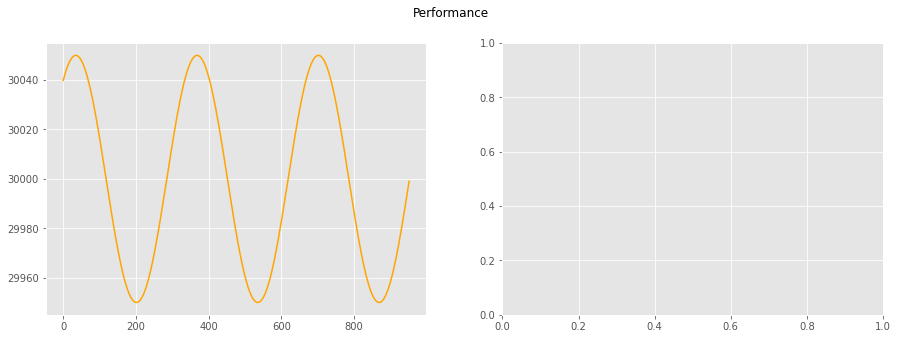

In [49]:
# Instantiate the environment
env = create_env({
    "window_size": 25,
    "df": df
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

## Performance and Net Worth Plotting

In [ ]:
def show_performance(df, price_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Performance')

    df.plot(ax=axs[0], grid=True, fontsize=12)
    df.net_worth.plot(ax=axs[1], grid=True, legend=True)
    price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

    plt.interactive(True)
    plt.show(block=True)

In [ ]:
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
#show_performance(performance, price_history)

In [ ]:
net_worth = performance.net_worth[len(performance.net_worth)-1]
print(f"Net worth = {net_worth} USD")

pnl = 100*(net_worth/initial_capital - 1)
print(f"PNL = {pnl} %")

In [ ]:
#env.action_scheme.portfolio.performance

(pid=21298) 2021-07-16 11:59:12,163	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=21298) 2021-07-16 11:59:12,163	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7febb7228730>: Box(-inf, inf, (25, 2), float32) -> (25, 2)
(pid=21298) 2021-07-16 11:59:12,168	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=21298) 2021-07-16 11:59:12,169	DEBUG rollout_worker.py:538 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7febb71e4550> (<TradingEnv instance>), policies {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7febb71e4580>}
(pid=21298) /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to t